# Interfacing with an external GMQL service: Aggregating the Chip-Seq signal of histone marks on promotorial regions

In this first application, genes' promoters are extracted from a local dataset and a large set of Chip-Seq experiments is selected from a remote repository. Then, for every promoter and for every Chip-seq experiment, the average signal of those Chip-Seq peaks intersecting the promoter is computed. The result is finally visualized as a heatmap, with rows representing promoters and columns  representing Chip-Seq experiments. 

This example shows: 
1. the integration of local PyGMQL programs with remote repositories,
2. the possibility to outsource the execution to an external deployment of (Py)GMQL, 
3. the interplay between PyGMQL data and Python libraries written by third parties. 
These features allow users to write arbitrary complex queries - whose execution and size of the inputs exceed the capabilities of the local environment - and, at the same time, analyze/visualize the output by means of well known Python libraries. 

In [1]:
import gmql as gl
import matplotlib.pyplot as plt

The code begins by loading a local dataset of gene annotations and extracting their promotorial regions (here defined as regions at $\left[gene_{start}-2000;gene_{start}+2000\right])$.
Note that the `start` and `stop` attributes automatically consider the strand of the region.

In [2]:
genes = gl.load_from_path("../data/genes/")

In [3]:
promoters = genes.reg_project(new_field_dict={
                'start':genes.start-2000, 
                'stop':genes.start + 2000})

The `genes` and `promoters` variables are `GMQLDataset`; the former is loaded directly, the latter results from a projection operation. Region feature names can be accessed directly from variables to build expressions and predicates (e.g., `gene.start + 2000`). 

Next, we load the external dataset of Chip-Seq from a remote GMQL Web service; in order to do so, the user has to specify the remote address and login. If the user has already signed to the remote GMQL installation, he/she can use his/her own credentials (this will also grant the access to private datasets), otherwise a guest account is automatically created, without requiring the user to do it manually.

In [4]:
gl.set_remote_address("http://gmql.eu/gmql-rest/")
gl.login()

[PyGMQL] Logging using stored authentication token


In the following snippet we show how to load the Chip-Seq data of the ENCODE dataset from the remote GMQL repository and select only the experiments of interest.
First, the user sets the `remote` execution mode and imports remote datasets with the `load_from_remote` function; such loading is *lazy*, therefore no actual data is moved or read at this point.
Then the user specifies the select condition; the `hms["experiment\_target"]` notation enables the user to build predicates on the given metadata attribute. The GMQL engine loads from the dataset only the samples whose metadata satisfy such condition; specifically, only experiments targeting the *human H3K9ac marker* will be selected.

In [5]:
gl.set_mode("remote")

In [6]:
hms = gl.load_from_remote("HG19_ENCODE_BROAD_AUG_2017",
                          owner="public")
hms_ac = hms[hms["experiment_target"] == "H3K9ac-human"]

Next, the PyGMQL `map` operation is used to compute the average of the signal of `hms_ac` intersecting each promoter; iteration over all samples is implicit. Finally, the `materialize` method triggers the execution of the query.
Since the mode is set to \texttt{"remote"}, the dataset stored at `./genes` is sent to the remote service GMQL system that performs the specified operations. The result is loaded into the `mapping` `GDataframe` variable which resides on the local machine.

In [7]:
mapping = promoters.map(
             hms_ac, 
             refName='prom', 
             expName='hm',
             new_reg_fields={
                'avg_signal': gl.AVG('signal')})
mapping = mapping.materialize()

100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


DS_CREATION_RUNNING..

100%|██████████| 44/44 [00:00<00:00, 219.17it/s]

At this point, Python libraries for data manipulation, visualization or analysis can be applied to the `GDataframe`. The following portion of code provides an example of data manipulation of a query result. The `to_matrix` method transforms the `GDataframe` into a *Pandas* matrix, where each row corresponds to a gene and each column to a cell line; values are the average signal on the promoter of the given gene in the given cell line. Finally, the matrix is visualized as a heatmap.

In [8]:
import seaborn as sns
heatmap=mapping.to_matrix(
                columns_meta=['hm.biosample_term_name'],
                index_regs=['gene_symbol'], 
                values_regs=['avg_signal'],
                fill_value=0)

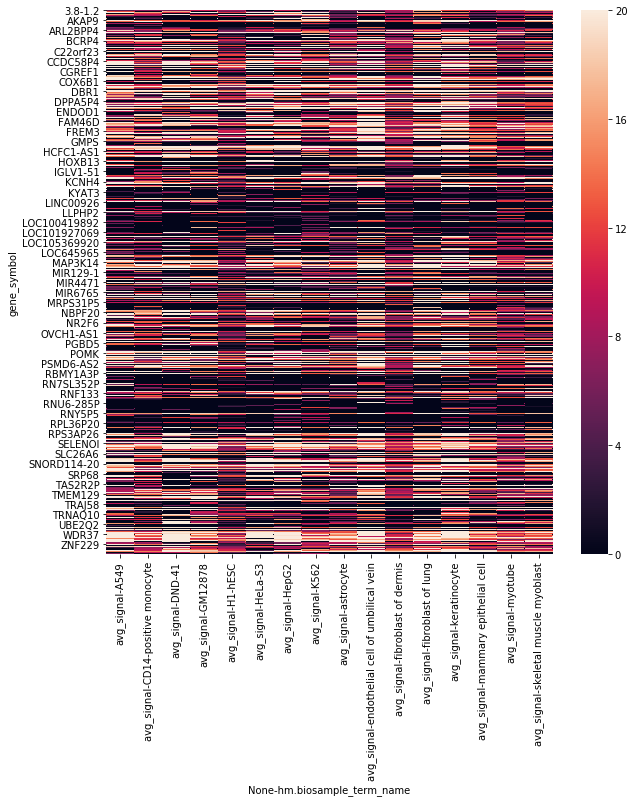

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap,vmax = 20)
plt.show()